Priority Sampling vs. Monte Carlo
=================================

This notebook accompanies the post on the [Graduate Descent](http://timvieira.github.io/blog) blog.

In [47]:
from __future__ import division
import numpy as np
import pylab as pl
from arsenal.iterview import iterview
from arsenal.math import compare, spherical
from collections import defaultdict

n = 50       # dimensionality
R = 20000    # replications

# probability vector
p = np.random.dirichlet(np.ones(n))

# random function.
f = spherical(n)

U = range(n)
true = p.dot(f)

data = defaultdict(lambda: np.zeros((R, n)))
for z in iterview(xrange(R)):

    # Monte Carlo
    s = np.random.choice(U, size=n, p=p, replace=1)   # sample n elements up front
    r = np.cumsum(f[s]) / (1+np.arange(n))            # running average gives each k<=n
    data['mc'][z] = r

    # Priority sampling
    u = np.random.uniform(0,1,size=n)
    key = p / u
    order = np.argsort(-key)
    sortd = key[order]                                # sample up front (for efficiency)

    # report what we would have gotten for each k<=n
    r = np.zeros(n)
    for k in range(1, n+1):
        t = sortd[k] if k < n else -np.inf            # threshold is the (k+1)th element
        S = order[:k]                                 # sample is the set of elements in top-k.
        r[k-1] = f[S].dot(np.maximum(p[S], t))

    data['ps'][z] = r

100.0% (20000/20000) [================================================] 00:00:08


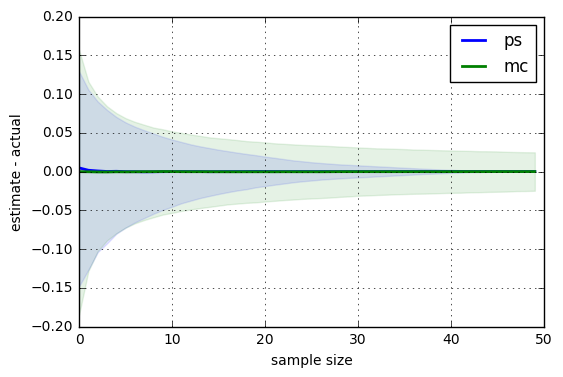

In [48]:
colors = {
    'mc': 'g',
    'ps': 'b',
}

ax = pl.figure().add_subplot(111)
for name, runs in data.items():
    c = colors[name]
    if not len(runs):
        continue
    l = len(runs[0])
    runs = np.array(runs) - true
    ax.plot(runs.mean(axis=0), c=c, lw=2, label=name)
    # Show error bars
    delta = 0.1
    ax.fill_between(range(l),
                    np.percentile(runs, 100*delta, axis=0),
                    np.percentile(runs, 100*(1-delta), axis=0),
                    color=c, alpha=0.1)

ax.grid(True)
pl.xlabel('sample size')
pl.ylabel('estimate - actual')
pl.legend(loc='best')
pl.show()